# Notebook 1: Introduction with linear Williamson 2

This document will provide an introduction to Gusto by going through an example script of the Williamson 2 test case. We will start with a linear version and then move to the non-linear version. 

We begin by importing the required libraries and functions from Firedrake and Gusto

In [1]:
from gusto import *
from firedrake import IcosahedralSphereMesh, SpatialCoordinate, as_vector
from math import pi
import sys

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


Set up the time parameters. The dumpfreq gives at how many time-steps we want to output results.

In [2]:
dt = 3000.
tmax = 30000.
dumpfreq = 1 

day = 24.*60.*60.

In [3]:
# setup shallow water parameters
R = 6371220.
H = 5960.

# setup input that doesn't change with ref level or dt
parameters = ShallowWaterParameters(H=H)

In [4]:
#Set up the mesh and choose the refinement level
refinements = 3  # number of horizontal cells = 20*(4^refinements)

mesh = IcosahedralSphereMesh(radius=R,
                             refinement_level=refinements, degree=3)
x = SpatialCoordinate(mesh)
mesh.init_cell_orientations(x)


We need to specify an output directory name before running the code. To prevent overwriting data, gusto will not enable overwriting an existing file - so a simulation needs to have different setup for it to run

In [5]:
output = OutputParameters(dirname='sw_linear_w2_dt%s' % dt,
                          dumpfreq=dumpfreq,
                          steady_state_error_fields=['u', 'D'],
                          log_level='INFO')

Let's define some diagnostics to output to check that the simulation parameters are fine.
It is useful to look at these over a shorter simulation before running a larger one.

In [6]:
diagnostic_fields = [RelativeVorticity(), PotentialVorticity(),
                         ShallowWaterKineticEnergy(),
                         ShallowWaterPotentialEnergy(),
                         ShallowWaterPotentialEnstrophy(),
                        CourantNumber()]

Now, we can specify a State, which we will update at each time-step using the time-stepper routine.

In [7]:
state = State(mesh,
              dt=dt,
              output=output,
              parameters=parameters,
              diagnostic_fields=diagnostic_fields)

gusto:INFO Physical parameters that take non-default values:
gusto:INFO H: 5960.0


In [8]:
#Create a spatially varying function for the Coriolis force:
Omega = parameters.Omega
x = SpatialCoordinate(mesh)
fexpr = 2*Omega*x[2]/R
eqns = LinearShallowWaterEquations(state, "BDM", 1, fexpr=fexpr)

Set up the initial conditions:
Due to the choice of function spaces for the velocity and depth, the intialisations are performed using projection 
and interpolation proceedures respectively.

In [9]:
u0 = state.fields("u")
D0 = state.fields("D")
u_max = 2*pi*R/(12*day)  # Maximum amplitude of the zonal wind (m/s)
uexpr = as_vector([-u_max*x[1]/R, u_max*x[0]/R, 0.0])
g = parameters.g
Dexpr = H - ((R * Omega * u_max)*(x[2]*x[2]/(R*R)))/g
u0.project(uexpr)
D0.interpolate(Dexpr)

Coefficient(WithGeometry(IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f706e647190>, FiniteElement('Discontinuous Lagrange', triangle, 1, variant='equispaced'), name='DG1', index=1, component=None), Mesh(VectorElement(FiniteElement('Lagrange', Cell('triangle', 3), 3), dim=3), 4)), 26)

In [10]:
#Now, construct the time-stepper. We will firstly use a semi-implicit (?) approach.
#We will neglect any transport schemes for now.
transport_schemes = [ImplicitMidpoint(state, "u"),
                          SSPRK3(state, "D", subcycles=2)]
stepper = CrankNicolson(state, eqns, transport_schemes)

In [11]:
#Run the time-stepper and generate the output
stepper.run(t=0, tmax=tmax)

/home/timandrews/firedrake/src/firedrake/firedrake/checkpointing.py:89: DeprecationWarning: DumbCheckpoint class will be deprecated after 01/01/2023; use CheckpointFile class instead.
  warnings.warn("DumbCheckpoint class will be deprecated after 01/01/2023; use CheckpointFile class instead.",
gusto:INFO at start of timestep, t=0, dt=3000.0
gusto:INFO at start of timestep, t=3000.0, dt=3000.0
gusto:INFO at start of timestep, t=6000.0, dt=3000.0
gusto:INFO at start of timestep, t=9000.0, dt=3000.0
gusto:INFO at start of timestep, t=12000.0, dt=3000.0
gusto:INFO at start of timestep, t=15000.0, dt=3000.0
gusto:INFO at start of timestep, t=18000.0, dt=3000.0
gusto:INFO at start of timestep, t=21000.0, dt=3000.0
gusto:INFO at start of timestep, t=24000.0, dt=3000.0
gusto:INFO at start of timestep, t=27000.0, dt=3000.0
gusto:INFO TIMELOOP complete. t=30000.0, tmax=30000.0


Now, let's check that we have successfully recorded the output. Get gusto to output the file names in the results 
directory to check that we have recorded the correct data.

Let's plot the diagnostics to check that we used a suitable time step. As the diagnostics are outputted in a .nc file, we need to import a specific library to read the information.

In [12]:
from netCDF4 import Dataset
import numpy as np
from matplotlib import pyplot as plt

nc = Dataset('results/sw_linear_w2_dt%s/diagnostics.nc' % dt,'r')

Let's check that we recorded the diagnostics we wanted

In [13]:
#Look at the recorded diagnostics:
print(nc.groups)

{'u': <class 'netCDF4._netCDF4.Group'>
group /u:
    dimensions(sizes): 
    variables(dimensions): float64 min(time), float64 max(time), float64 rms(time), float64 l2(time), float64 total(time)
    groups: , 'D': <class 'netCDF4._netCDF4.Group'>
group /D:
    dimensions(sizes): 
    variables(dimensions): float64 min(time), float64 max(time), float64 rms(time), float64 l2(time), float64 total(time)
    groups: , 'D_error': <class 'netCDF4._netCDF4.Group'>
group /D_error:
    dimensions(sizes): 
    variables(dimensions): float64 min(time), float64 max(time), float64 rms(time), float64 l2(time), float64 total(time)
    groups: , 'u_error': <class 'netCDF4._netCDF4.Group'>
group /u_error:
    dimensions(sizes): 
    variables(dimensions): float64 min(time), float64 max(time), float64 rms(time), float64 l2(time), float64 total(time)
    groups: , 'CourantNumber': <class 'netCDF4._netCDF4.Group'>
group /CourantNumber:
    dimensions(sizes): 
    variables(dimensions): float64 min(time), f

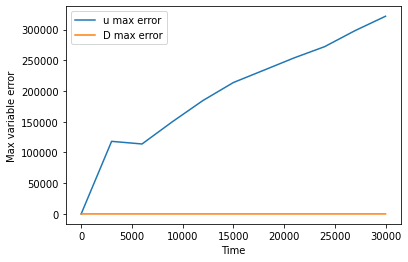

In [14]:
u_err = nc.groups['u_error']
D_err = nc.groups['D_error']

u_err_max = np.asarray(u_err.variables['max'])
D_err_max = np.asarray(D_err.variables['max'])

times = np.asarray(nc.variables['time'])

plt.figure()
plt.plot(times,u_err_max,label='u max error')
plt.plot(times,D_err_max,label='D max error')
plt.xlabel('Time')
plt.ylabel('Max variable error')
plt.legend()

In [15]:
Cr_no = nc.groups['CourantNumber']

Cr_max = np.asarray(Cr_no.variables['max'])
Cr_rms = np.asarray(Cr_no.variables['rms'])

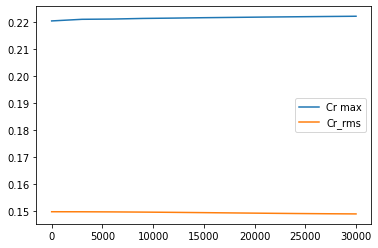

In [16]:
plt.figure()
plt.plot(times,Cr_max,label='Cr max')
plt.plot(times,Cr_rms,label='Cr_rms')
plt.legend()

Oh no, it looks like we used too large a time step for the velocity! Let's re-run the simulation with 
half the time step.

In [17]:
dt_new = dt/2

output_new = OutputParameters(dirname='sw_linear_w2_dt%s' % dt_new,
                          dumpfreq=dumpfreq,
                          steady_state_error_fields=['u', 'D'],
                          log_level='INFO')

diagnostic_fields = [RelativeVorticity(), PotentialVorticity(),
                         ShallowWaterKineticEnergy(),
                         ShallowWaterPotentialEnergy(),
                         ShallowWaterPotentialEnstrophy(),
                        CourantNumber()]

state = State(mesh,
              dt=dt_new,
              output=output_new,
              parameters=parameters,
              diagnostic_fields=diagnostic_fields)

gusto:INFO Physical parameters that take non-default values:
gusto:INFO H: 5960.0


Coefficient(WithGeometry(IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f706e647190>, FiniteElement('Discontinuous Lagrange', triangle, 1, variant='equispaced'), name='DG1', index=1, component=None), Mesh(VectorElement(FiniteElement('Lagrange', Cell('triangle', 3), 3), dim=3), 4)), 596)

In [ ]:
Omega = parameters.Omega
x = SpatialCoordinate(mesh)
fexpr = 2*Omega*x[2]/R
eqns = LinearShallowWaterEquations(state, "BDM", 1, fexpr=fexpr)

u0 = state.fields("u")
D0 = state.fields("D")
u_max = 2*pi*R/(12*day)  # Maximum amplitude of the zonal wind (m/s)
uexpr = as_vector([-u_max*x[1]/R, u_max*x[0]/R, 0.0])
g = parameters.g
Dexpr = - ((R * Omega * u_max)*(x[2]*x[2]/(R*R)))/g
u0.project(uexpr)
D0.interpolate(Dexpr)

In [18]:
stepper = CrankNicolson(state, eqns, transport_schemes)
stepper.run(t=0, tmax=tmax)

/home/timandrews/firedrake/src/firedrake/firedrake/checkpointing.py:89: DeprecationWarning: DumbCheckpoint class will be deprecated after 01/01/2023; use CheckpointFile class instead.
  warnings.warn("DumbCheckpoint class will be deprecated after 01/01/2023; use CheckpointFile class instead.",
gusto:INFO at start of timestep, t=0, dt=1500.0
gusto:INFO at start of timestep, t=1500.0, dt=1500.0
gusto:INFO at start of timestep, t=3000.0, dt=1500.0
gusto:INFO at start of timestep, t=4500.0, dt=1500.0
gusto:INFO at start of timestep, t=6000.0, dt=1500.0
gusto:INFO at start of timestep, t=7500.0, dt=1500.0
gusto:INFO at start of timestep, t=9000.0, dt=1500.0
gusto:INFO at start of timestep, t=10500.0, dt=1500.0
gusto:INFO at start of timestep, t=12000.0, dt=1500.0
gusto:INFO at start of timestep, t=13500.0, dt=1500.0
gusto:INFO at start of timestep, t=15000.0, dt=1500.0
gusto:INFO at start of timestep, t=16500.0, dt=1500.0
gusto:INFO at start of timestep, t=18000.0, dt=1500.0
gusto:INFO at s

Let's check the errors now:

In [19]:
nc = Dataset('results/sw_linear_w2_dt%s/diagnostics.nc' % dt_new,'r')

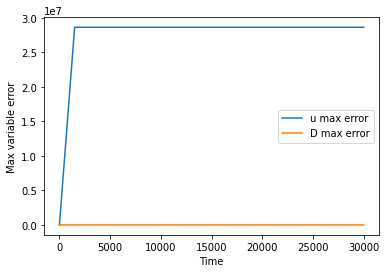

In [20]:
u_err = nc.groups['u_error']
D_err = nc.groups['D_error']

u_err_max = np.asarray(u_err.variables['max'])
D_err_max = np.asarray(D_err.variables['max'])

times = np.asarray(nc.variables['time'])

plt.figure()
plt.plot(times,u_err_max,label='u max error')
plt.plot(times,D_err_max,label='D max error')
plt.xlabel('Time')
plt.ylabel('Max variable error')
plt.legend()

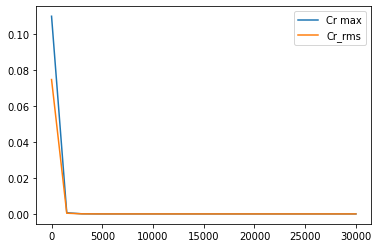

In [21]:
Cr_no = nc.groups['CourantNumber']

Cr_max = np.asarray(Cr_no.variables['max'])
Cr_rms = np.asarray(Cr_no.variables['rms'])

plt.figure()
plt.plot(times,Cr_max,label='Cr max')
plt.plot(times,Cr_rms,label='Cr_rms')
plt.legend()

EXERCISE: Visualise some other parameters between the two simulations to check that we are now using a sufficiently
small time step